# Coding Challenge: *Stanford Health Care* Biomedical Informatics Data Scientist


## *Imports and Reading in Data*

In [28]:
# Import packages for data analysis and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%config InlineBackend.figure_format = 'retina'

In [29]:
# Read in all data tables from dataset
person_df = pd.read_csv("Coding_challenge_dataset/person_1000.csv", index_col=0)
death_df = pd.read_csv("Coding_challenge_dataset/death_1000.csv", index_col=0)
location_df = pd.read_csv("Coding_challenge_dataset/location_1000.csv", index_col=0)
condition_occurrence_df = pd.read_csv('Coding_challenge_dataset/condition_occurrence_1000.csv', index_col=0)
drug_exposure_df = pd.read_csv('Coding_challenge_dataset/drug_exposure_1000.csv', index_col=0)
concept_df = pd.read_csv("Coding_challenge_dataset/concept_1000.csv", index_col=0)

/var/folders/fh/5d__cjxd4sz4gl3sczjn84800000gn/T/ipykernel_53073/2599788611.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  drug_exposure_df = pd.read_csv('Coding_challenge_dataset/drug_exposure_1000.csv', index_col=0)


In [1156]:
# Colors for visualization
stanford_red = '#8C1515'
stanford_grey = '#53565A'

# 1. Data Quality

## **a. Which variables in the person table have missing values? What number and proportion of those variables are missing?**

### 1a. Answer

After inspecting the person table, I see that the following 6 variables have missing values: birth_DATETIME, provider_id, care_site_id, gender_source_concept_id . race_source_concept_id, ethnicity_source_concept_id.

Each of these 6 variables is completely missing for all 1000 rows (all entries are null).

I also checked the unique values in case NA values were assigned to non-standard codes for any variables (e.g., birth year of 0 instead NaN).


### 1a. Code & Work

In [31]:
# Check for null values
person_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_id                    1000 non-null   int64  
 1   gender_concept_id            1000 non-null   int64  
 2   year_of_birth                1000 non-null   int64  
 3   month_of_birth               1000 non-null   int64  
 4   day_of_birth                 1000 non-null   int64  
 5   birth_DATETIME               0 non-null      float64
 6   race_concept_id              1000 non-null   int64  
 7   ethnicity_concept_id         1000 non-null   int64  
 8   location_id                  1000 non-null   int64  
 9   provider_id                  0 non-null      float64
 10  care_site_id                 0 non-null      float64
 11  person_source_value          1000 non-null   object 
 12  gender_source_value          1000 non-null   int64  
 13  gender_source_concept_id

In [82]:
# Count missing values and save variables with missing values
missing_values = person_df.isnull().sum()
missing_values_vars = missing_values[missing_values > 0].reset_index(name='count_NA')

In [95]:
# Calculate proportion of missing values and save variables with missing values
missing_proportion = missing_values/len(person_df)
missing_prop_vars = missing_proportion[missing_proportion > 0].reset_index(name='proportion_NA')

In [91]:
# Merge missing count and missing proportion for table
missing_values_table = pd.merge(missing_values_vars, missing_prop_vars, on='index').rename(columns={'index':'variable'})
missing_values_table

,variable,count_NA,proportion_NA
0,birth_DATETIME,1000,1.0
1,provider_id,1000,1.0
2,care_site_id,1000,1.0
3,gender_source_concept_id,1000,1.0
4,race_source_concept_id,1000,1.0
5,ethnicity_source_concept_id,1000,1.0


### 1a. Visualization

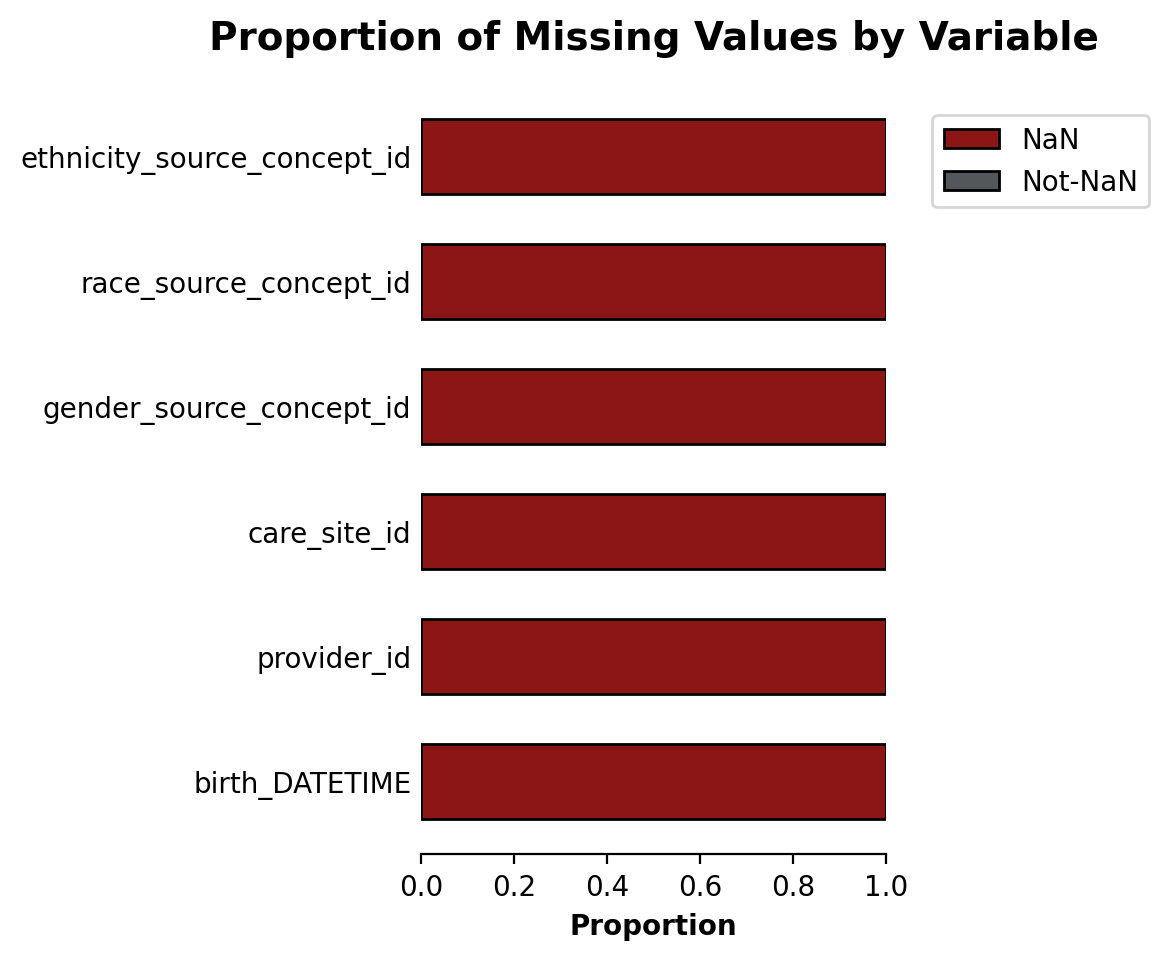

In [1173]:
# Prepare data for plotting
variables = missing_values_table['variable']
proportion_NA = missing_values_table['proportion_NA']
proportion_not_NA = 1 - missing_values_table['proportion_NA']

# Plot the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(3, 5))
ax.barh(variables, proportion_NA, color=stanford_red, label='NaN', height=0.6, edgecolor='black')
ax.barh(variables, proportion_not_NA, left=proportion_NA, color=stanford_grey, label='Not-NaN', height=0.6, edgecolor='black')

# Customize the plot
ax.set_xlabel('Proportion', fontweight='bold')
ax.set_title('Proportion of Missing Values by Variable', fontweight='bold', pad=12.5, fontsize=14)

ax.tick_params(axis='y', length=0)  # Remove y-tick marks but keep labels

ax.legend(['NaN', 'Not-NaN'], bbox_to_anchor=(1.1, .96), loc='upper left', borderaxespad=0)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **b. Which variables in the person table have suspicious-looking values? (Choose 3 suspicious values to list, and explain why they are not what you expect).**

### 1b. Answer

**Some variables have only 1 unique value.** Every patient’s month_of_birth and day_of_birth is reported as “1”. This is suspicious because it is unlikely that everyone in the sample has the same birth month and day. Further, all patients are categorized as 'White' with an ethnicity of 'Not Hispanic or Latino.' For a sample of 1000, it is unlikely that everyone is of the same race and ethnicity.


**Birth year data is suspiciously distributed.** More than 60% of the patients are born before the year 1919. This is suspicious because the dates in the conditions occurrence and drug exposure tables are between 2007 and 2010, making a majority of the patients very elderly (some older than 100). Further, there are no patients born between 1919 and 1963. This is unexpected because it suggests there are no middle aged patients in this dataset, which raises questions about completeness and accuracy.


**Gender is reported as a binary variable.** The variable gender_concept_id has only two unique values (Male and Female), but there is likely to be transgender people within a sample of 1000. This is suspicious as it may be unrepresentative of the population. It may also be dangerous to exclude this information because transgender patients may require special consideration, for instance, when being given a drug that could alter hormone levels.


### 1b. Code & Work

In [1064]:
# Investigate min, max, mean and variance of variables
person_df.describe()

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_DATETIME,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id
count,1000.000000,1000.000000,1000.000000,1000.0,1000.0,0.0,1000.0,1000.0,1000.000000,0.0,0.0,1000.000000,0.0,1000.0,0.0,1000.0,0.0
mean,91141.607000,8520.750000,1935.944000,1.0,1.0,NaN,8527.0,38003564.0,676.696000,NaN,NaN,1.550000,NaN,1.0,NaN,1.0,NaN
std,55701.707039,12.443566,28.630728,0.0,0.0,NaN,0.0,0.0,686.893469,NaN,NaN,0.497743,NaN,0.0,NaN,0.0,NaN
min,35.000000,8507.000000,1909.000000,1.0,1.0,NaN,8527.0,38003564.0,4.000000,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN
25%,42951.500000,8507.000000,1913.000000,1.0,1.0,NaN,8527.0,38003564.0,145.000000,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN
50%,89376.500000,8532.000000,1917.000000,1.0,1.0,NaN,8527.0,38003564.0,414.500000,NaN,NaN,2.000000,NaN,1.0,NaN,1.0,NaN
75%,131992.500000,8532.000000,1969.000000,1.0,1.0,NaN,8527.0,38003564.0,1026.750000,NaN,NaN,2.000000,NaN,1.0,NaN,1.0,NaN
max,217190.000000,8532.000000,1983.000000,1.0,1.0,NaN,8527.0,38003564.0,3154.000000,NaN,NaN,2.000000,NaN,1.0,NaN,1.0,NaN


In [114]:
# Check the unique values for each variable (excluidng those that are completely missing)
for column in person_df.columns:
    if person_df[column].isna().sum() != 1000:
        print(column)
        print(len(person_df[column].value_counts()), "unique values")
        print(person_df[column].value_counts(dropna=False).reset_index())
        print()

person_id
1000 unique values
['count', 'person_id']

gender_concept_id
2 unique values
['count', 'gender_concept_id']

year_of_birth
30 unique values
['count', 'year_of_birth']

month_of_birth
1 unique values
['count', 'month_of_birth']

day_of_birth
1 unique values
['count', 'day_of_birth']

race_concept_id
1 unique values
['count', 'race_concept_id']

ethnicity_concept_id
1 unique values
['count', 'ethnicity_concept_id']

location_id
571 unique values
['count', 'location_id']

person_source_value
1000 unique values
['count', 'person_source_value']

gender_source_value
2 unique values
['count', 'gender_source_value']

race_source_value
1 unique values
['count', 'race_source_value']

ethnicity_source_value
1 unique values
['count', 'ethnicity_source_value']

race_concept_name
1 unique values
['count', 'race_concept_name']

ethnicity_concept_name
1 unique values
['count', 'ethnicity_concept_name']

gender_concept_name
2 unique values
['count', 'gender_concept_name']



In [119]:
# Look at year of birth closer
person_df['year_of_birth'].value_counts().reset_index().sort_values(by='year_of_birth')

,year_of_birth,count
3,1909,63
9,1910,50
4,1911,63
8,1912,51
5,1913,62
1,1914,67
7,1915,60
6,1916,62
0,1917,74
2,1918,66


In [155]:
# See count of patients born before 1919
(person_df['year_of_birth'] <= 1918).sum()

618

In [113]:
# Create a dictionary that maps form concept_id to concept_name for efficiency (avoid constant merging)
concept_dict = {id: name for id, name in concept_df[['concept_id', 'concept_name']].values}

# Make new columns with race, ethnicity, and gender concept IDs mapped to their concept names
person_df['race_concept_name'] = [concept_dict[id] for id in person_df['race_concept_id'].values]
person_df['ethnicity_concept_name'] = [concept_dict[id] for id in person_df['ethnicity_concept_id'].values]
person_df['gender_concept_name'] = [concept_dict[id] for id in person_df['gender_concept_id'].values]

# Check unique values for race, ethnicity, and gender concept name
for column in ['race_concept_name', 'ethnicity_concept_name', 'gender_concept_name']:
    print(column)
    print(len(person_df[column].value_counts()), "unique values")
    print(person_df[column].value_counts(dropna=False).reset_index())
    print()

race_concept_name
1 unique values
  race_concept_name  count
0             White   1000

ethnicity_concept_name
1 unique values
   ethnicity_concept_name  count
0  Not Hispanic or Latino   1000

gender_concept_name
2 unique values
  gender_concept_name  count
0              FEMALE    550
1                MALE    450



# 2. Concepts

## **a. What is the concept ID for Congestive Heart Failure?**

### 2a. Answer

The concept ID for Congestive Heart Failure is 319835. 

This concept ID corresponds to the SNOMED code for "Congestive heart failure", which specifically and clearly identifies Congestive Heart Failure without additional comorbid conditions or unspecified details—making it a precise and reliable choice for data analysis and machine learning.

The concept table contains conditions comorbid with Congestive Heart Failure such as "Hypertensive heart disease with congestive heart failure" (concept ID 314378), "Benign hypertensive heart disease with congestive heart failure" (concept ID 312338), and "Malignant hypertensive heart disease with congestive heart failure" (concept ID 316994). The concept table also includes "Congestive heart failure, unspecified" (concept ID 44826642) which has a concept_class_id of '4-dig billing code' and vocabulary_id of 'ICD9CM', while the previously mentioned concepts have vocabulary_id of 'SNOMED'. ICD-9-CM codes are often used for billing and may not capture all clinical nuances.


### 2a. Code & Work

In [861]:
# Filter the concept table for just concept names containing 'congestive heart failure'
congestive_heart_failure_df = concept_df[concept_df['concept_name'].str.contains('congestive heart failure', case=False)]
congestive_heart_failure_df

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason
7333,314378,Hypertensive heart disease with congestive hea...,Condition,SNOMED,Clinical Finding,S,5148006,1970-01-01,2099-12-31,NaN
8738,314369,Malignant hypertensive heart disease without c...,Condition,SNOMED,Clinical Finding,S,36315003,1970-01-01,2099-12-31,NaN
9031,319835,Congestive heart failure,Condition,SNOMED,Clinical Finding,S,42343007,1970-01-01,2099-12-31,NaN
9864,319034,Hypertensive heart disease without congestive ...,Condition,SNOMED,Clinical Finding,S,60899001,1970-01-01,2099-12-31,NaN
10622,312338,Benign hypertensive heart disease with congest...,Condition,SNOMED,Clinical Finding,S,77737007,1970-01-01,2099-12-31,NaN
10637,313502,Benign hypertensive heart disease without cong...,Condition,SNOMED,Clinical Finding,S,77970009,1970-01-01,2099-12-31,NaN
10871,316994,Malignant hypertensive heart disease with cong...,Condition,SNOMED,Clinical Finding,S,83105008,1970-01-01,2099-12-31,NaN
16498,44826642,"Congestive heart failure, unspecified",Condition,ICD9CM,4-dig billing code,NaN,428.0,1970-01-01,2099-12-31,NaN


In [862]:
# Check full names of conditions
for id, name in congestive_heart_failure_df[['concept_id', 'concept_name']].values:
    print(id, name)

314378 Hypertensive heart disease with congestive heart failure
314369 Malignant hypertensive heart disease without congestive heart failure
319835 Congestive heart failure
319034 Hypertensive heart disease without congestive heart failure
312338 Benign hypertensive heart disease with congestive heart failure
313502 Benign hypertensive heart disease without congestive heart failure
316994 Malignant hypertensive heart disease with congestive heart failure
44826642 Congestive heart failure, unspecified


## **b. What clinical concept is represented by the concept ID of 8507?**

### 2b. Answer

If I query the concept table where "concept_id = 8507", I see that concept ID corresponds with the gender concept name 'MALE'.

### 2b. Code & Work

In [157]:
# Filter concept table to find concept name for ID 8507
concept_df[concept_df['concept_id'] == 8507]

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason
50,8507,MALE,Gender,Gender,Gender,S,M,1970-01-01,2099-12-31,NaN


# 3. Characteristics

## **a. How many patients are there for each year included in the dataset?**

### 3a. Answer

To answer the question, I report the number of patients per year as the number of unique person_id's grouped by year in any of the condition_occurrence, drug_exposure, and death tables. 

Below is a bar chart displaying the patient count values.

### 3a. Code & Work

In [160]:
# Concatenate the dataframes with dates in them
patient_data = pd.concat([condition_occurrence_df, death_df, drug_exposure_df], ignore_index=True)

# Filter for just columns related to dates
date_columns = ['condition_start_DATE', 'condition_end_DATE', 'death_DATE', 'drug_exposure_start_DATE', 'drug_exposure_end_DATE']
patient_data_filtered = patient_data[np.append('person_id', date_columns)]

In [162]:
# Convert date columns to datetime
for col in date_columns:
    patient_data_filtered.loc[:, col] = pd.to_datetime(patient_data_filtered[col], errors='coerce')

In [163]:
# Melt the dataframe to combine all date columns into a single column
melted_df = patient_data_filtered.melt(id_vars=['person_id'], 
                                       value_vars=date_columns, 
                                       var_name='date_type', 
                                       value_name='date')

In [164]:
# Drop NaN dates and extract year
melted_df = melted_df.dropna(subset=['date'])
melted_df['year'] = melted_df['date'].dt.year

In [167]:
# Get number of unique patients per year
unique_patients_per_year = melted_df.groupby('year')['person_id'].nunique().reset_index(name='unique_patient_count')

# Get number of unique patients per year AND date type
unique_patients_per_year_type = melted_df.groupby(['year', 'date_type'])['person_id'].nunique().reset_index(name='unique_patient_count')

In [168]:
# Pivot to create columns for each date_type
pivot_df = unique_patients_per_year_type.pivot(index='year', 
                                               columns='date_type', 
                                               values='unique_patient_count').reset_index()

In [169]:
# Merge with unique_patients_per_year and fill NA
result_df = unique_patients_per_year.merge(pivot_df, on='year', how='left').fillna(0).astype(int)
result_df

,year,unique_patient_count,condition_end_DATE,condition_start_DATE,death_DATE,drug_exposure_end_DATE,drug_exposure_start_DATE
0,2007,7,0,7,0,0,3
1,2008,866,779,779,10,808,811
2,2009,875,815,815,17,854,855
3,2010,857,787,787,8,820,806
4,2011,222,0,0,0,222,0


In [170]:
unique_patients_per_year

,year,unique_patient_count
0,2007,7
1,2008,866
2,2009,875
3,2010,857
4,2011,222


### 3a. Visualization

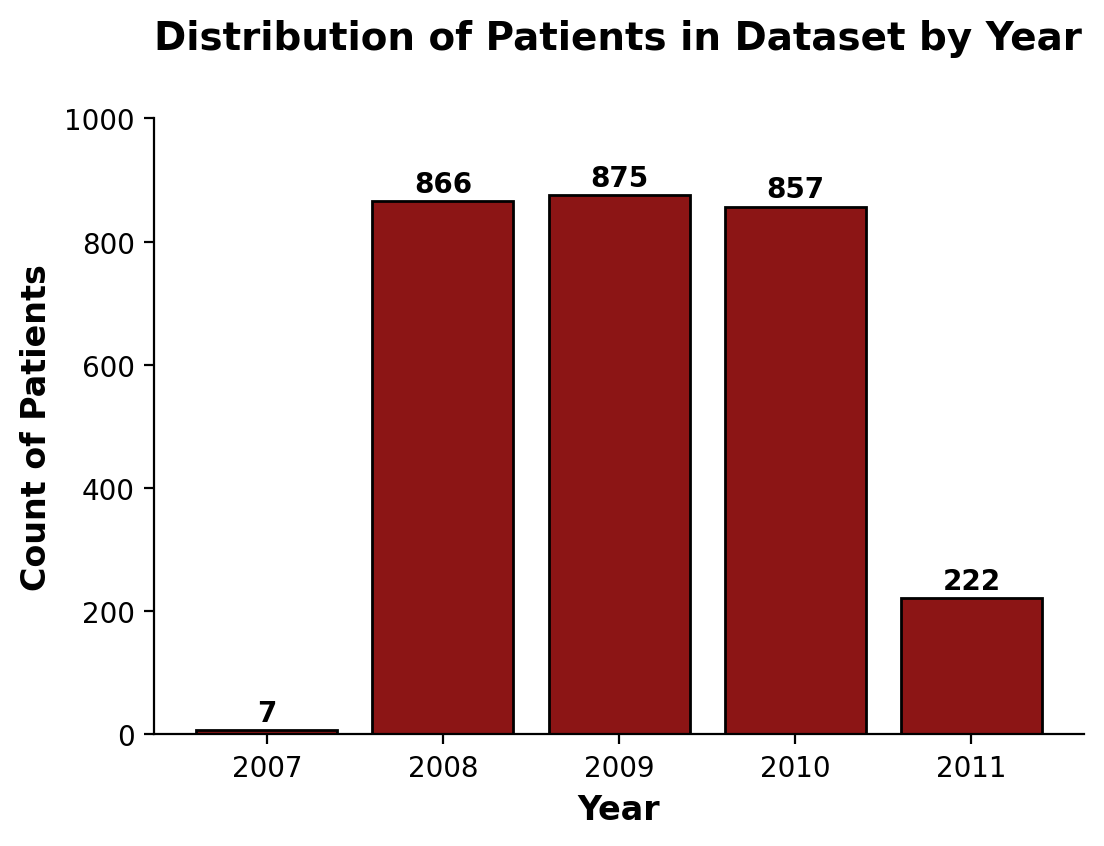

In [1177]:
# Plot patient count using barchart
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(unique_patients_per_year['year'],
              unique_patients_per_year['unique_patient_count'],
              color=stanford_red,
              edgecolor='black')

# Add count as text above each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontweight='bold')

# Customize the plot
ax.set_ylim(0,1000)

ax.set_ylabel('Count of Patients', fontweight='bold', fontsize=12)
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_title("Distribution of Patients in Dataset by Year", fontweight='bold', pad=25, fontsize=14, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **b. What are the distributions of patients by race, ethnicity, and gender?**

### 3b. Answer

Race has only one unique value, 'White'. Ethnicity also only has one unique value, 'Not Hispanic or Latino'. As stated earlier, this uniform distribution is likely due to an error in the dataset. 

Gender is distributed with 550 female and 450 male patients.

### 3b. Code & Work

In [218]:
# Get patient counts by race
race_counts = person_df['race_concept_name'].value_counts().reset_index()
print(race_counts)
print()

# Get patient counts by ethnicity
ethnicity_counts = person_df['ethnicity_concept_name'].value_counts().reset_index()
print(ethnicity_counts)
print()

# Get patient counts by gender
gender_counts = person_df['gender_concept_name'].value_counts().reset_index()
print(gender_counts)

  race_concept_name  count
0             White   1000

   ethnicity_concept_name  count
0  Not Hispanic or Latino   1000

  gender_concept_name  count
0              FEMALE    550
1                MALE    450


### 3b. Visualization

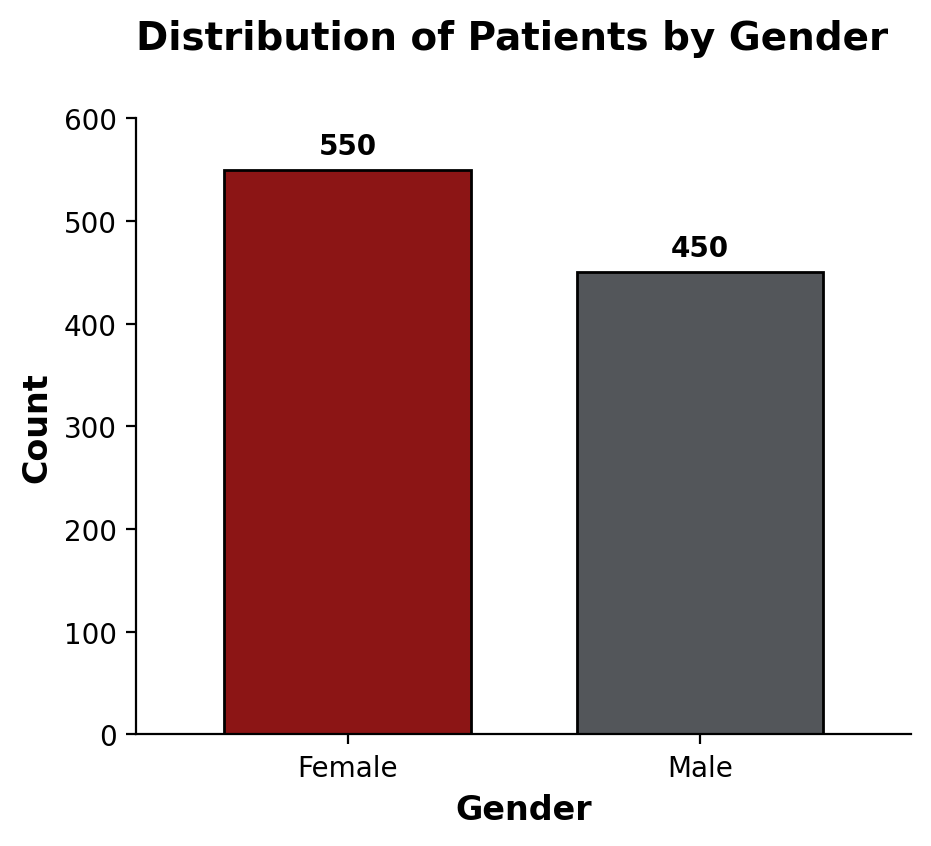

In [750]:
# Plot patient gender in barchart
fig, ax = plt.subplots(figsize=(5,4))

bars = ax.bar(gender_counts['gender_concept_name'],
              gender_counts['count'],
              color=[stanford_red, stanford_grey],
              width=.7,
              edgecolor='black')

# Add count as text above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontweight='bold')

# Customize plot
ax.set_xlim([-.6, 1.6])
ax.set_ylim([0, 600])

ax.set_xticks([0, 1])
ax.set_xticklabels(['Female', 'Male'])

ax.set_xlabel('Gender', fontweight='bold', fontsize=12)
ax.set_ylabel('Count', fontweight='bold', fontsize=12)
ax.set_title("Distribution of Patients by Gender", fontweight='bold', pad=25, fontsize=14, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **c. What is the distribution of patients by year of birth and month of birth?**

### 3c. Answer

All the patients in the dataset have a birth month of January, so the distribution of birth month is uniform. This is highly unlikely and indicates a potential data entry error or an issue with the data source.

The distribution of birth years is bimodal with two distinct clusters of younger and older patients. The large gap between 1919 and 1963 raises questions of dataset completeness—assuming this was not an intentional choice in cohort selection. With a more complete dataset, I would hypothesize the distribution to be right-skewed as there are notably more older patients.


### 3c. Code & Work

In [360]:
# Sanity check that birth month is "1" for all patients
assert person_df['month_of_birth'].unique() == 1

In [1167]:
# Get count of patients grouped by birth year
patients_per_birth_year_df = person_df.groupby('year_of_birth')['person_id'].count().reset_index(name='number_of_patients')

In [364]:
# Make array spanning min to max year of birth
min_year = person_df['year_of_birth'].min()
max_year = person_df['year_of_birth'].max()
span_of_birth_years = np.arange(min_year, max_year + 1)

# Get the unique years of birth in dataset
unique_birth_years = person_df['year_of_birth'].unique()

# Check for missing years
missing_years = set(span_of_birth_years) - set(unique_birth_years)

if missing_years:
    print(f"Missing years in the dataset: {sorted(missing_years)}")
else:
    print(f"All years are present between {min_year} and {max_year}.")

Missing years in the dataset: [1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963]


### 3c. Visualization

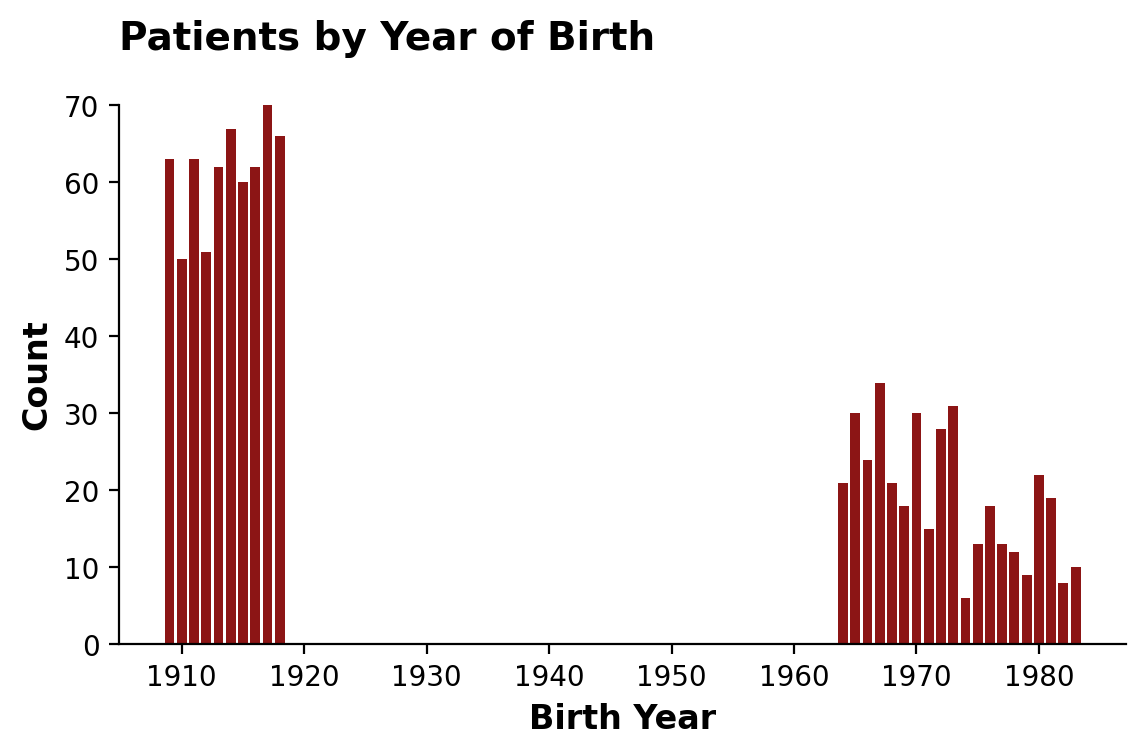

In [768]:
# Prepare data for plot
years = person_df['year_of_birth'].unique()
counts = person_df.groupby('year_of_birth')['person_id'].count().values

# Plot birth year counts in bar chart
fig, ax = plt.subplots(figsize=(6.5, 3.5))

ax.bar(years, counts, color=stanford_red)

# Customize plot
ax.set_title("Patients by Year of Birth", fontweight='bold', fontsize=14, loc='left', pad=20) 
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.set_xlabel("Birth Year", fontweight='bold', fontsize=12)

ax.set_ylim(0,70)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **d. What is the distribution of patients in different states? Which states have the most patients? And the least?**

### 3d. Answer

The heatmap suggests coastal and northeast states have the most patients while midwest and western states have fewer.

States with most patients:
- California (86)
- Florida (61)
- Pennsylvania (60)
- New York (57)

States with least patients:
- Hawaii (1)
- Vermont (2) tied
- Montana (2) tied
- Delaware (3)

This data contains a state labeled as '54' and is also missing the state Alaska. Perhaps Alaska was miscoded as '54'. In practice, I would inquire with the data source to gain more insight.

### 3d. Code & Work

In [367]:
# Subset location table
location_id_state_df = location_df[['location_id', 'state']]

# Merge people table with subsetted location table
person_state_df = pd.merge(person_df, location_id_state_df, on='location_id')

In [409]:
# Group by state to get number of patients per state
patients_per_state = person_state_df.groupby('state')['person_id'].count().reset_index(name='number_of_patients')

In [370]:
# Inspect patients given weird value in state code "54"
person_state_df.query('state == "54"')

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_DATETIME,race_concept_id,ethnicity_concept_id,location_id,provider_id,...,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,race_concept_name,ethnicity_concept_name,gender_concept_name,state
294,115693,8507,1914,1,1,NaN,8527,38003564,153,NaN,...,1,NaN,1,NaN,1,NaN,White,Not Hispanic or Latino,MALE,54
363,168826,8507,1916,1,1,NaN,8527,38003564,1608,NaN,...,1,NaN,1,NaN,1,NaN,White,Not Hispanic or Latino,MALE,54
506,68124,8507,1967,1,1,NaN,8527,38003564,2615,NaN,...,1,NaN,1,NaN,1,NaN,White,Not Hispanic or Latino,MALE,54


In [1207]:
# Do not include counts of invalid state ID '54'
patients_per_valid_state = patients_per_state[patients_per_state['state'] != '54']

In [630]:
# Check if all 50 states are in the dataset
states = patients_per_valid_state['state']

assert len(states) == 50, f"Only {len(states)} states in dataset"

AssertionError: Only 49 states in dataset

In [631]:
# Sort by count
patients_per_valid_state = patients_per_valid_state.sort_values(by='number_of_patients', ascending=False).reset_index(drop=True)

In [632]:
# Check for ties in the counts
values = patients_per_valid_state['number_of_patients']

assert len(values) == len(set(values)), f"There are states with tied value counts. Inspect closely"

AssertionError: There are states with tied value counts. Inspect closely

In [651]:
# Check top few
top_few_states = patients_per_valid_state[:4]
top_few_states

,state,number_of_patients
0,CA,86
1,FL,61
2,PA,60
3,NY,57


In [643]:
# Check bottom few
bottom_few_states = patients_per_valid_state[-4:]
bottom_few_states

,state,number_of_patients
45,DE,3
46,VT,2
47,MT,2
48,HI,1


### 3d. Visualization

In [780]:
# Use plotly to plot geographic state data
fig = px.choropleth(
    patients_per_valid_state,
    locations='state',
    locationmode='USA-states',
    color='number_of_patients',
    scope='usa',
    color_continuous_scale='Reds',
    title='<b>Geographic Distribution of Patients by U.S. State</b>'
)

# Update layout for title and legend
fig.update_layout(
    title={
        'text': '<b>Geographic Distribution of Patients by U.S. State</b>',
        'font': {'size': 24, 'weight': 'bold', 'color': 'black'},
        'x': 0.5,
        'xanchor': 'center'
        },
    
    coloraxis_colorbar={
        'title': {'text': 'Number of Patients', 'font': {'size': 16, 'color': 'black'}}
        }
)

fig.show()

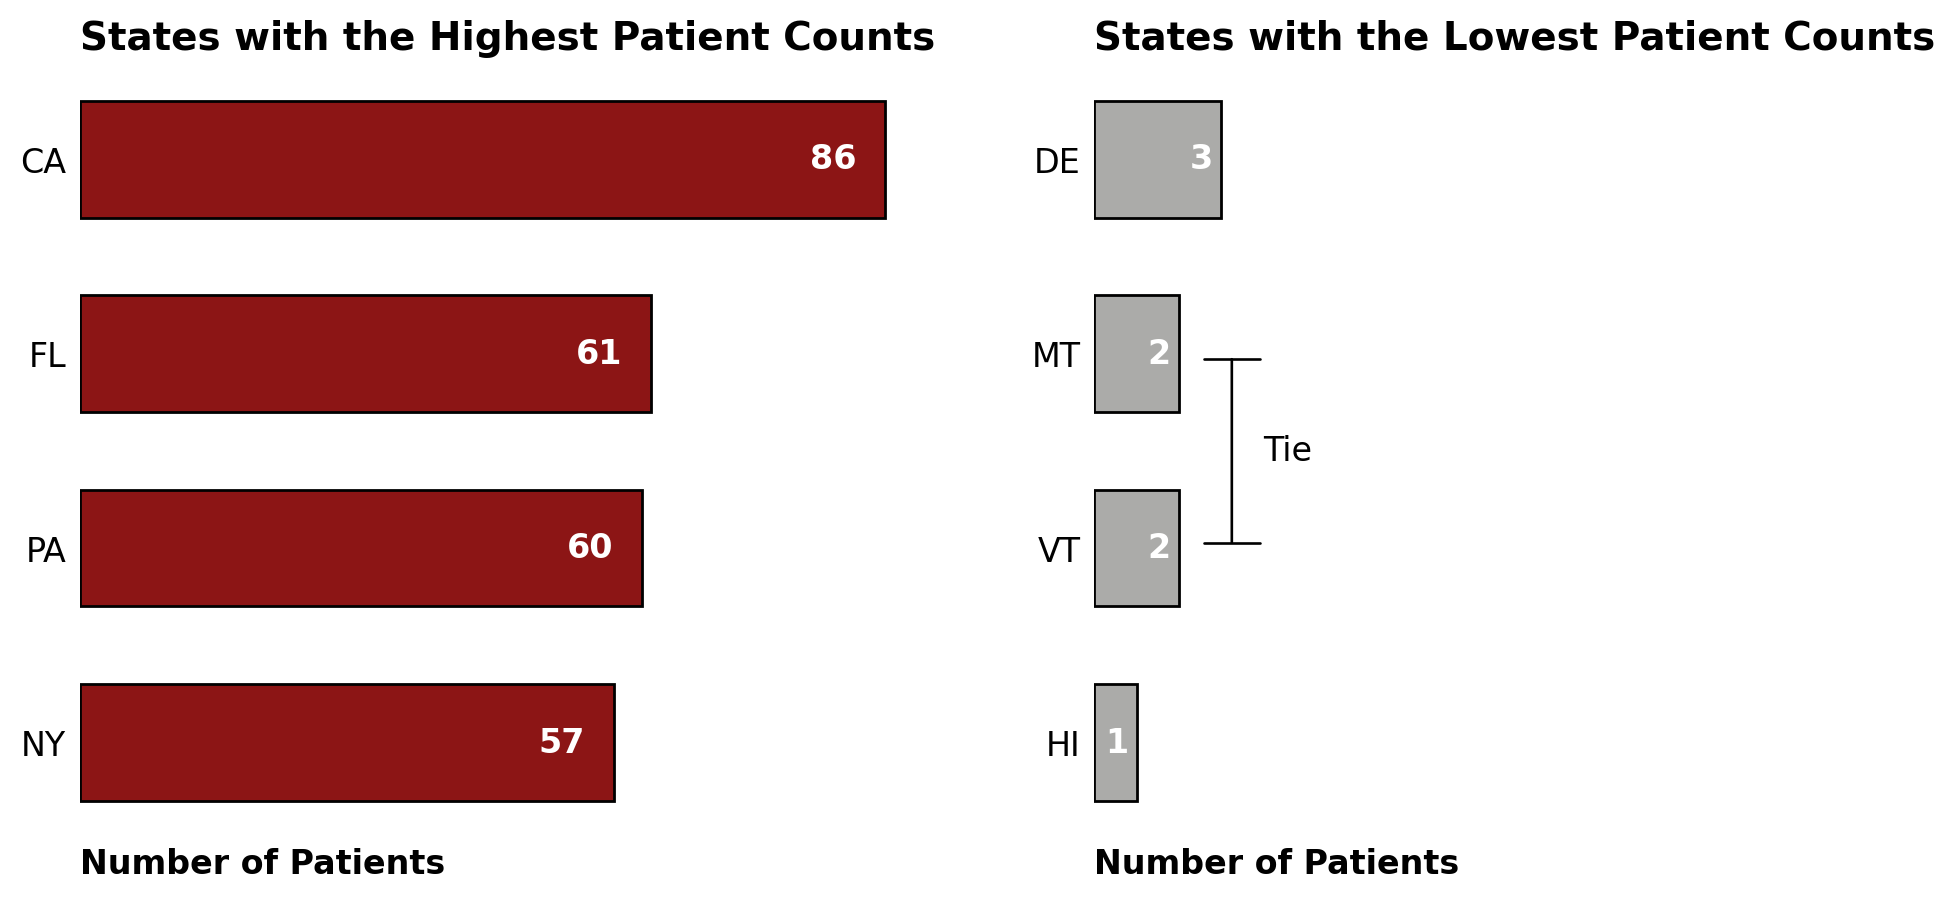

In [1161]:
# Prepare data for barchart
top_few_states_sorted = top_few_states.sort_values(by='number_of_patients', ascending=True)
bottom_few_states_sorted = bottom_few_states.sort_values(by='number_of_patients', ascending=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# Plot the top states
axes[0].barh(top_few_states_sorted['state'], top_few_states_sorted['number_of_patients'], color=stanford_red, height=0.6, edgecolor='black')
axes[0].set_title("States with the Highest Patient Counts", fontweight='bold', fontsize=14, loc='left')

# Add values next to the bars for top states
for index, value in enumerate(top_few_states_sorted['number_of_patients']):
    axes[0].text(value-8, index, str(value), va='center', ha='left', fontweight='bold', color='white', fontsize=12)


axes[0].set_xlabel("Number of Patients", loc='left', fontweight='bold', fontsize=12)
axes[0].set_xticks([])
axes[0].tick_params(axis='y', length=0, labelsize=12)  # Remove y-tick marks but keep labels
axes[0].yaxis.set_tick_params(pad=5)

axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['right'].set_visible(False)


# Plot the bottom states
axes[1].barh(bottom_few_states_sorted['state'], bottom_few_states_sorted['number_of_patients'], color='#ABABA9', height=0.6, edgecolor='black')

# Add values next to the bars for top states
for index, value in enumerate(bottom_few_states_sorted['number_of_patients']):
    axes[1].text(value-.75, index, str(value), va='center', ha='left', fontweight='bold', color='white', fontsize=12)


axes[1].set_title("States with the Lowest Patient Counts", fontweight='bold', fontsize=14, loc='left')
axes[1].set_xlabel("Number of Patients", loc='left', fontweight='bold', fontsize=12)

axes[1].tick_params(axis='y', length=0, labelsize=12)  # Remove y-tick marks but keep labels
axes[1].yaxis.set_tick_params(pad=5)

axes[1].set_xlim(0, 20)
axes[1].set_xticks([])

axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Add the bracket and "Tied" label
bracket_start = bottom_few_states_sorted.index.get_loc(bottom_few_states_sorted[bottom_few_states_sorted['state'] == 'MT'].index[0])
bracket_end = bottom_few_states_sorted.index.get_loc(bottom_few_states_sorted[bottom_few_states_sorted['state'] == 'VT'].index[0])

axes[1].annotate('', xy=(3.25, bracket_start), xytext=(3.25, bracket_end),
                 arrowprops=dict(arrowstyle='|-|', lw=.95, color='black'))

axes[1].text(4, (bracket_start + bracket_end) / 2, 'Tie', va='center', ha='left', fontsize=12)

plt.show()

## **e. How many of these patients have death data? Which state had the most deaths? Are there any states that saw no deaths?**

### 3e. Answer

35 patients have death data. 

Florida had the most deaths (4). 

There are 26 states in the dataset with no deaths. 

We can not make any inferences regarding Alaska as it is not explicitly included in the location table.

### 3e. Code & Work

In [776]:
# Get number of unique people in the death table
death_df['person_id'].nunique()

35

In [803]:
# Check that the patients with death data exist in the person df
assert np.all(np.isin(death_df['person_id'], person_df['person_id']))

# Merge death data and previously merged person_state table
person_state_death_df = pd.merge(person_state_df, death_df, on='person_id')

In [821]:
# Get count of deaths group by state
deaths_per_state = person_state_death_df['state'].value_counts().reset_index(name='number_of_deaths')

# Sort by value
deaths_per_state_sorted = deaths_per_state.sort_values(by='number_of_deaths', ascending=False)

In [816]:
# Check states with most deaths 
deaths_per_state_sorted[:5]

,state,number_of_deaths
4,FL,4
14,NY,3
21,VA,3
2,CA,2
3,CT,2


In [823]:
# Get states with no deaths (check states in person_df but not in death_df)
states_with_no_deaths = [state for state in patients_per_valid_state['state'].values if state not in deaths_per_state['state'].values]

# Check which states had no deaths
print(states_with_no_deaths, '\n')

# Check how many states with no deaths
print(f'There are {len(states_with_no_deaths)} states with no deaths.')

['MI', 'MA', 'NC', 'WI', 'GA', 'TN', 'CO', 'AL', 'MD', 'NE', 'NH', 'WV', 'MS', 'OK', 'ME', 'ID', 'KS', 'WY', 'NV', 'NM', 'SD', 'UT', 'DE', 'VT', 'MT', 'HI'] 

There are 26 states with no deaths.


## **f. Which year saw the most deaths?**

### 3f. Answer

The year 2009 saw the most deaths (17). 

### 3f. Code & Work

In [825]:
# Get year of death from death_DATE
death_df['year'] = [date[:4] for date in death_df['death_DATE']]

# Group patient death count by year
death_by_year = death_df.groupby('year')['person_id'].count().reset_index(name='number_of_deaths')
death_by_year

,year,number_of_deaths
0,2008,10
1,2009,17
2,2010,8


### 3f. Visualization

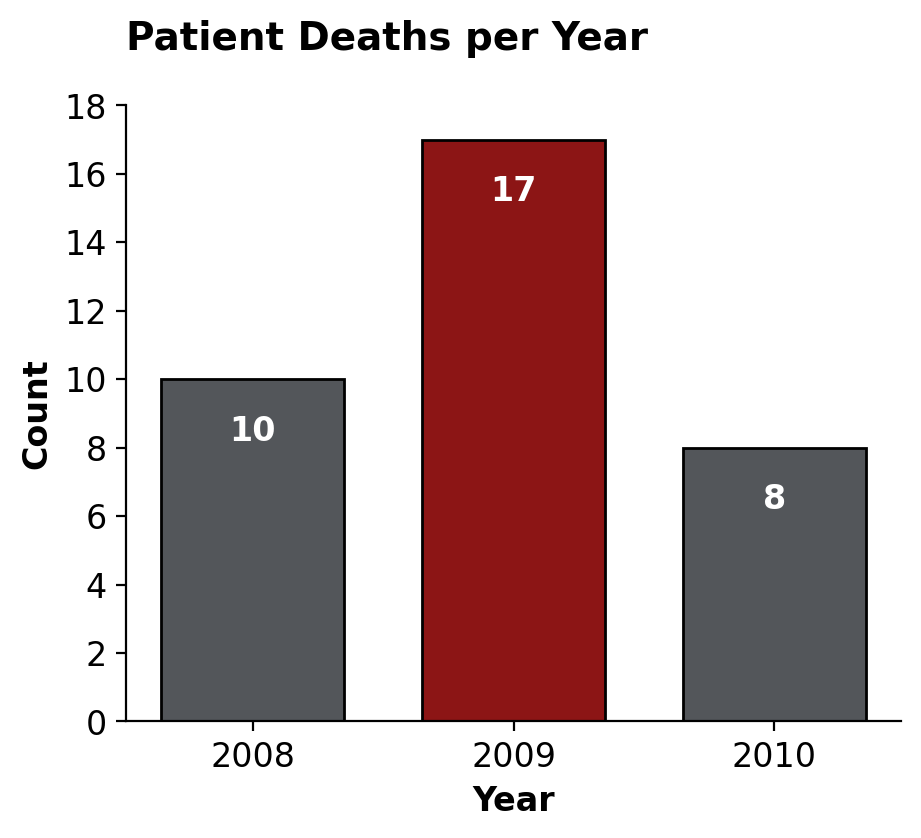

In [906]:
# Plot barchart
fig, ax = plt.subplots(figsize=(5,4))

bars = ax.bar(death_by_year['year'],
              death_by_year['number_of_deaths'],
              color=[stanford_grey, stanford_red, stanford_grey],
              width=.7,
              edgecolor='black')

# Add count as text above bars
for bar in bars:
    yval = bar.get_height()    
    ax.text(bar.get_x() + bar.get_width()/2, yval - 2, int(yval), ha='center', va='bottom', 
            fontweight='bold', color='white', fontsize=12)

# Customize plot
ax.set_ylim([0, 18])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Count', fontweight='bold', fontsize=12)
ax.set_title("Patient Deaths per Year", fontweight='bold', pad=20, fontsize=14, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


# 4. Conditions

## **a. What are the 5 most prevalent conditions in this dataset?**

### 4a. Answer

The five most prevalent conditions in the dataset are Type 2 diabetes mellitus, Atrial fibrillation, Chest pain, Anemia, and Pure hypercholesterolemia.

| Condition                  | Occurrence Count   |
|----------------------------|-------------------|
| Type 2 diabetes mellitus   | 5,507             |
| Atrial fibrillation        | 2,671             |
| Chest pain                 | 2,351             |
| Anemia                     | 1,928             |
| Pure hypercholesterolemia  | 1,884             |


### 4a. Code & Work

In [862]:
# Group by condition concept id to get condition counts 
condition_occurrence_count = condition_occurrence_df.groupby('condition_concept_id')['person_id'].count().reset_index(name='occurrence_count')

# Sort values to get top 5 conditions
top_five_conditions = condition_occurrence_count.sort_values('occurrence_count', ascending=False).reset_index(drop=True).iloc[:5]

# Map concept ID to concept name using concept dictionary
top_five_conditions['concept_name'] = [concept_dict[concept_id] for concept_id in top_five_conditions['condition_concept_id']]

# Show top 5 most prevalent conditions
top_five_conditions[['concept_name', 'occurrence_count']]

,concept_name,occurrence_count
0,Type 2 diabetes mellitus,5507
1,Atrial fibrillation,2671
2,Chest pain,2351
3,Anemia,1928
4,Pure hypercholesterolemia,1884


### 4a. Visualization

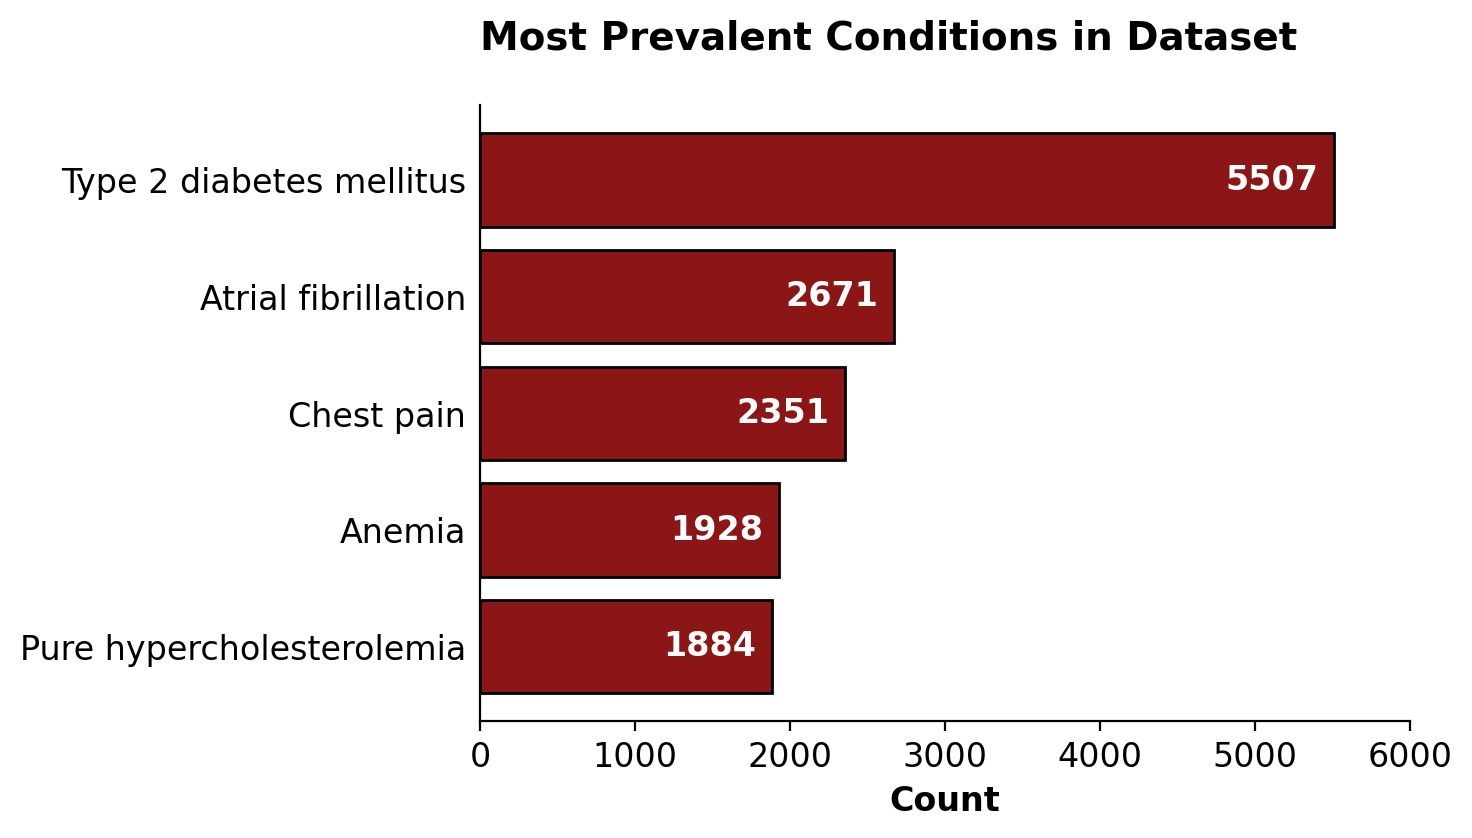

In [917]:
# Prepare data for plotting (get top 5 condition names and counts)
top_five_conditions = top_five_conditions.sort_values('occurrence_count', ascending=False).reset_index(drop=True).iloc[:5]
top_five_conditions = top_five_conditions.sort_values('occurrence_count', ascending=True)

# Plot top 5 conditions
fig, ax = plt.subplots(figsize=(6,4))

ax.barh(top_five_conditions['concept_name'],
         top_five_conditions['occurrence_count'],
         color=stanford_red,
         edgecolor='black')

# Add values next to the bars for top states
for index, value in enumerate(top_five_conditions['occurrence_count']):
    ax.text(value-700, index, str(value), va='center', ha='left', fontweight='bold', color='white', fontsize=12)


# Customize plot
ax.set_xlim(0,6000)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', length=0, labelsize=12, pad=5)

ax.set_xlabel('Count', fontweight='bold', fontsize=12)
ax.set_title("Most Prevalent Conditions in Dataset", fontweight='bold', pad=20, fontsize=14, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **b. Which condition was most prevalent in 2010?**

### 4b. Answer

The top condition in 2010 was Type 2 diabetes mellitus with 1366 occurrences. 

Here, I assume prevalence in 2010 indicates the condition start date is in 2010, the condition end date is in 2010, or the year 2010 falls between the condition start date and end date.

### 4b. Code & Work

In [873]:
# Convert condition start and end date to datetime and extract year
condition_occurrence_df['start_year'] = pd.to_datetime(condition_occurrence_df['condition_start_DATE']).dt.year
condition_occurrence_df['end_year'] = pd.to_datetime(condition_occurrence_df['condition_end_DATE']).dt.year

# Filter table to just 2010 
conditions_2010_df = condition_occurrence_df.query('(start_year == 2010) | (end_year == 2010)')

# Group by condition
condition_occurrence_2010_count = conditions_2010_df.groupby('condition_concept_id')['condition_occurrence_id'].count().reset_index(name='occurrence_count')

# Sort and retrieve top condition name and occurrence count
top_condition_2010 = condition_occurrence_2010_count.sort_values('occurrence_count', ascending=False).reset_index(drop=True).iloc[:1]

name = concept_dict[top_condition_2010['condition_concept_id'].values[0]]
count = top_condition_2010['occurrence_count'].values[0]

print(count, name)

1366 Type 2 diabetes mellitus


In [1184]:
# Check for edge case where condition began before 2010 and ended after 2010
assert len(condition_occurrence_df.query('(start_year < 2010) & (end_year > 2010)')) == 0

### 4b. Visualization

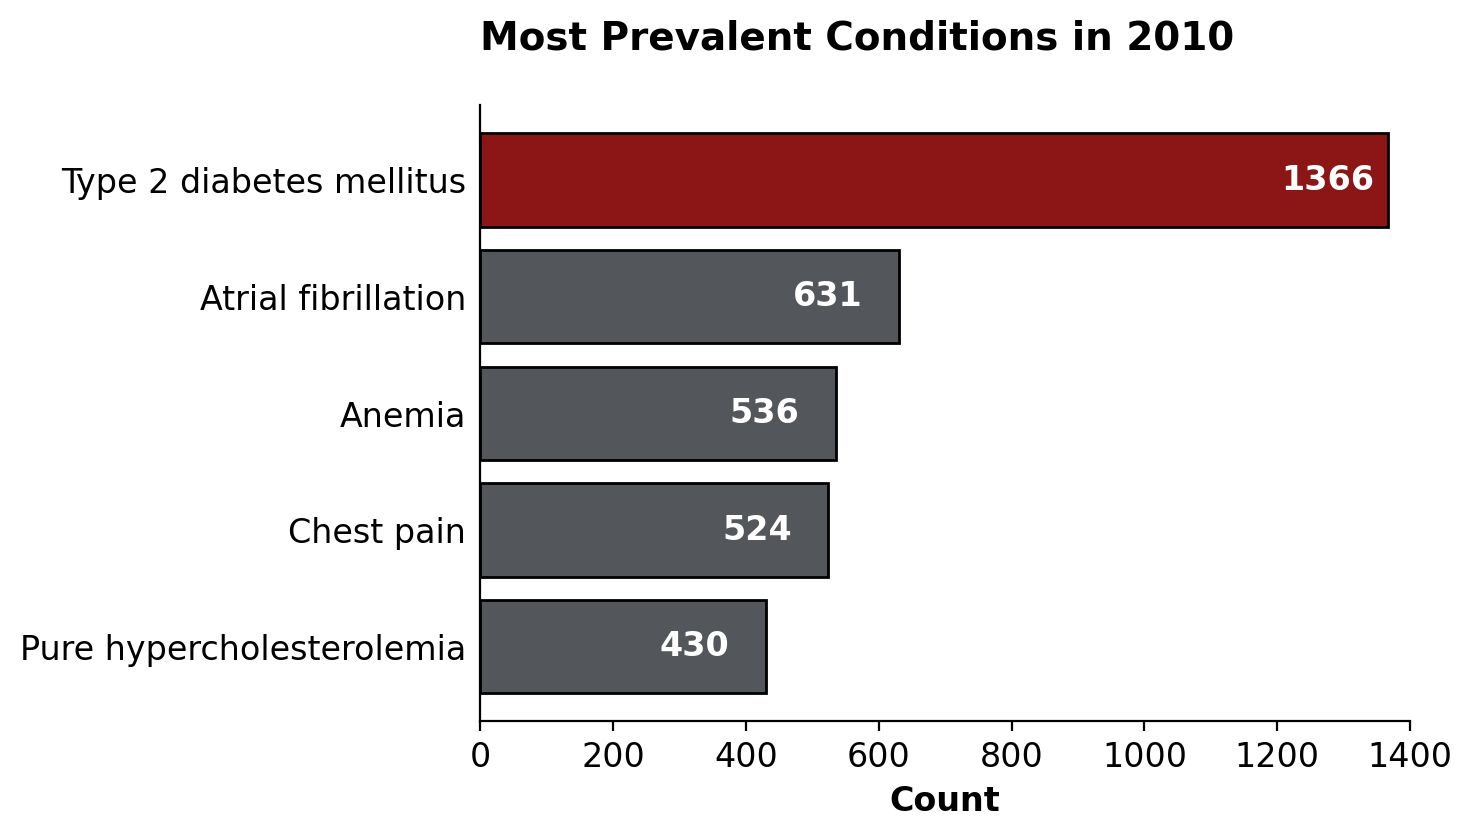

In [928]:
# Prepare data for plotting (get top 5 condition names and counts)
top_5_condition_2010 = condition_occurrence_2010_count.sort_values('occurrence_count', ascending=False).reset_index(drop=True).iloc[:5]
top_5_condition_2010['condition_name'] = [concept_dict[id] for id in top_5_condition_2010['condition_concept_id'].values]
top_5_condition_2010 = top_5_condition_2010.sort_values('occurrence_count', ascending=True)


# Plot top 5 conditions in 2010
fig, ax = plt.subplots(figsize=(6,4))

plt.barh(top_5_condition_2010['condition_name'],
         top_5_condition_2010['occurrence_count'],
         color=[stanford_grey, stanford_grey, stanford_grey, stanford_grey, stanford_red],
         edgecolor='black')

# Add values next to the bars for top states
for index, value in enumerate(top_5_condition_2010['occurrence_count']):
    ax.text(value-160, index, str(value), va='center', ha='left', fontweight='bold', color='white', fontsize=12)


# Customize plot
ax.set_xlim(0, 1400)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', length=0, labelsize=12, pad=5)

ax.set_xlabel('Count', fontweight='bold', fontsize=12)
ax.set_title("Most Prevalent Conditions in 2010", fontweight='bold', pad=20, fontsize=14, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **c. What was the most prevalent condition in CA (looking across all years)?**

### 4c. Answer

Type 2 diabetes mellitus was the most prevalent condition in CA across all years with 482 occurrences.

### 4c. Code & Work

In [888]:
# Merge person-state datafram and condition occurence table
state_condition_occurrence_df = pd.merge(person_state_df[['person_id', 'state']], condition_occurrence_df, on='person_id')

# Filter for CA
CA_condition_occurrence_df = state_condition_occurrence_df.query('state == "CA"')

# Group by condition and get counts
CA_condition_occurrence_count = CA_condition_occurrence_df.groupby('condition_concept_id')['person_id'].count().reset_index(name='occurrence_count')

# Sort and get top condition
top_condition_CA = CA_condition_occurrence_count.sort_values('occurrence_count', ascending=False).reset_index(drop=True).iloc[:1]

name = concept_dict[top_condition_CA['condition_concept_id'].values[0]]
count = top_condition_CA['occurrence_count'].values[0]

print(count, name)

482 Type 2 diabetes mellitus


### 4c. Visualization

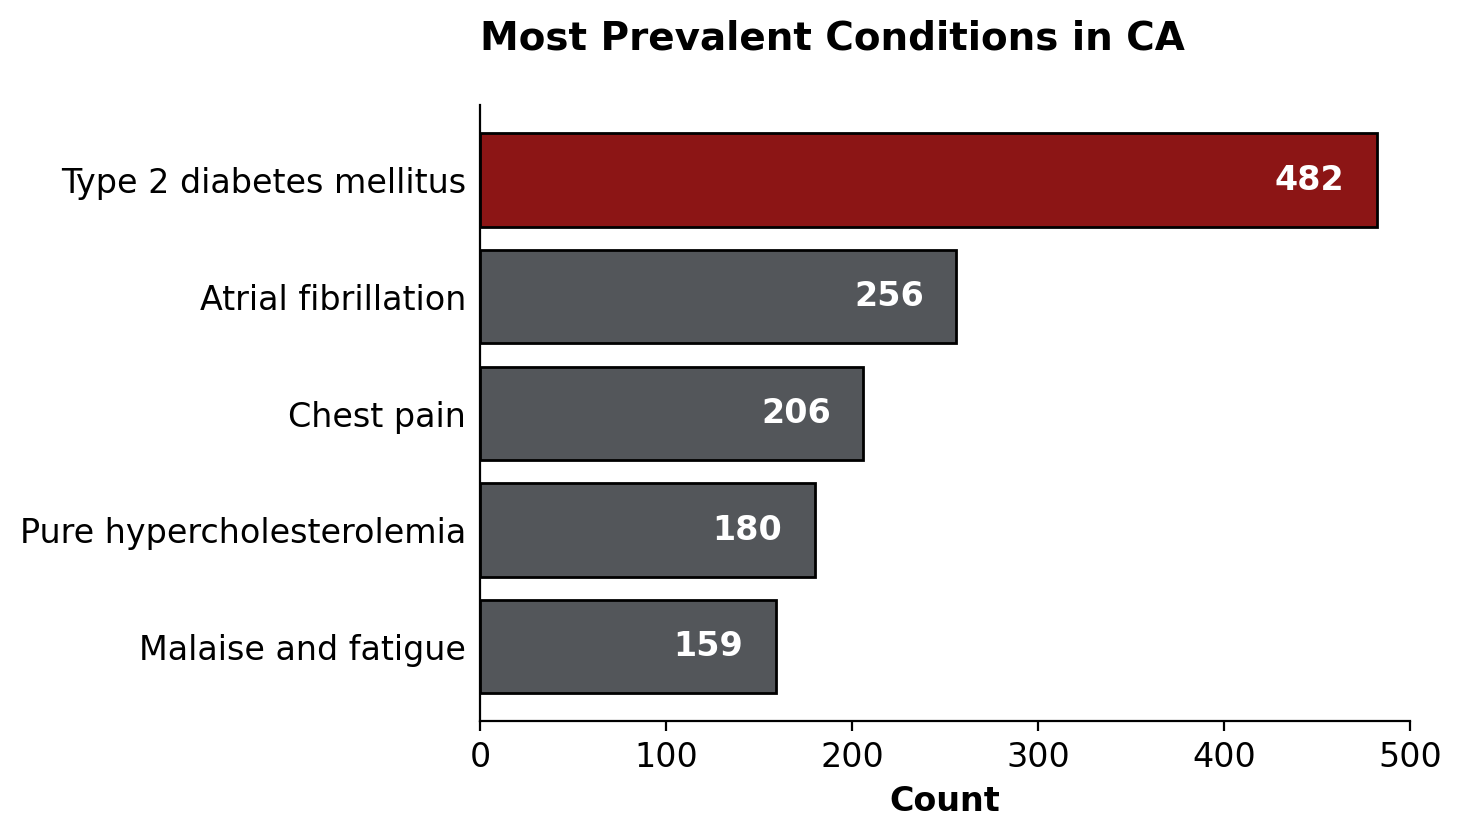

In [947]:
# Prepare data for plot (get top five conditions for CA)
top_5_conditions_CA = CA_condition_occurrence_count.sort_values('occurrence_count', ascending=False).reset_index(drop=True).iloc[:5]
top_5_conditions_CA['condition_name'] = [concept_dict[id] for id in top_5_conditions_CA['condition_concept_id'].values]
top_5_conditions_CA = top_5_conditions_CA.sort_values('occurrence_count', ascending=True)


# Plot top 5 conditions in CA
fig, ax = plt.subplots(figsize=(6,4))

plt.barh(top_5_conditions_CA['condition_name'],
         top_5_conditions_CA['occurrence_count'],
         color=[stanford_grey, stanford_grey, stanford_grey, stanford_grey, stanford_red],
         edgecolor='black')

# Add values next to the bars for top states
for index, value in enumerate(top_5_conditions_CA['occurrence_count']):
    ax.text(value-55, index, str(value), va='center', ha='left', fontweight='bold', color='white', fontsize=12)


# Customize plot
ax.set_xlim(0, 500)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', length=0, labelsize=12, pad=5)

ax.set_xlabel('Count', fontweight='bold', fontsize=12)
ax.set_title("Most Prevalent Conditions in CA", fontweight='bold', pad=20, fontsize=14, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **d. Which state had the highest incidence of Congestive Heart Failure across all years?**

### 4d. Answer

Florida had the highest incidence of Congestive Heart Failure (concept ID 319835) across all years with 157 occurrences. 

I assume “incidence of Congestive Heart Failure” is separate from incidence of conditions co-occurring with Congestive Heart Failure (e.g., Hypertensive heart disease with Congestive Heart Failure).


### 4d. Code & Work

In [988]:
# Remeber the ID for Congestive heart failure is 319835

# Query the combined state-condition dataframe for Congestive heart failure
chf_occurrence_df = state_condition_occurrence_df.query('condition_concept_id == 319835')

# Group by state and get counts
chf_occurrence_per_state = chf_occurrence_df.groupby('state')['person_id'].count().reset_index(name="chf_occurrence_count")

# Sort and get state with top value
top_chf_state = chf_occurrence_per_state.sort_values(by='chf_occurrence_count', ascending=False).reset_index(drop=True).iloc[:1]

state = top_chf_state['state'][0]
count = top_chf_state['chf_occurrence_count'][0]

print(state, count)

FL 157


### 4d. Visualization

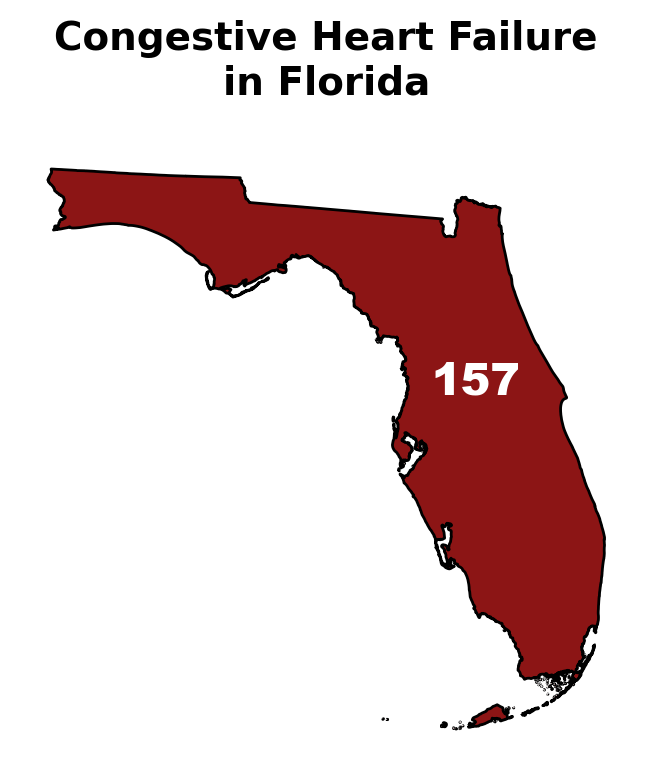

In [1001]:
# Prepare data for plot
count = top_chf_state['chf_occurrence_count'][0]

# Load shapefile for states
states = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

# Filter for Florida
florida = states[states['NAME'] == 'Florida']
florida = florida.to_crs(epsg=26917)

# Plot the map and FL
fig, ax = plt.subplots(figsize=(4, 4))
florida.plot(ax=ax, color=stanford_red, edgecolor='black')

# Add occurence count as text
x, y = florida.geometry.centroid.x.values[0], florida.geometry.centroid.y.values[0]
ax.text(x+70000, y, str(count), fontsize=16, ha='center', va='center', fontweight='bold', color='white', family="Arial Black")

# Customize the plot
ax.set_axis_off()
plt.title('Congestive Heart Failure\nin Florida', fontsize=14, fontweight='bold')

plt.show()

# 5. Drugs

## **a. What are the 5 most commonly used drugs?**

### 5a. Answer

The five most commonly used drugs are as follows: 
- Epoetin Alfa (1059)
- Influenza virus vaccine, trivalent (IIV3), split virus, 0.5 mL dosage, for intramuscular use (619)
- Paricalcitol Injectable Solution (553)
- Oxygen 99 % Gas for Inhalation (550)
- Omeprazole 20 MG Delayed Release Oral Capsule (345)

The most common concept id in the drug exposures table was associated with “No matching concept.” I excluded it for the purposes of this analysis.

I assume that the same drug at different doses can be considered a different drug—this way we do not lose any information. I interpret the "most commonly used drugs" as those with the highest number of entries in the drug exposure table.


### 5a. Code & Work

In [1002]:
# Get drug usage count, grouping by drug
drug_usage_count = drug_exposure_df.groupby('drug_concept_id')['drug_exposure_id'].count().reset_index(name='drug_use_count')

# Sort and get top 5 drugs
top_5_drugs = drug_usage_count.sort_values(by='drug_use_count', ascending=False).reset_index(drop=True).iloc[:6]

# Use concept dictionary to map IDs to names
top_5_drugs['drug_name'] = [concept_dict[concept_id] for concept_id in top_5_drugs['drug_concept_id']]

top_5_drugs

,drug_concept_id,drug_use_count,drug_name
0,0,1467,No matching concept
1,1301125,1059,Epoetin Alfa
2,2213440,619,"Influenza virus vaccine, trivalent (IIV3), spl..."
3,40098312,553,paricalcitol Injectable Solution
4,19025280,550,Oxygen 99 % Gas for Inhalation
5,19019418,345,Omeprazole 20 MG Delayed Release Oral Capsule


In [1003]:
# Drop the most common 'No matching concept'
top_5_drugs = top_5_drugs.drop(index=0)
top_5_drugs

,drug_concept_id,drug_use_count,drug_name
1,1301125,1059,Epoetin Alfa
2,2213440,619,"Influenza virus vaccine, trivalent (IIV3), spl..."
3,40098312,553,paricalcitol Injectable Solution
4,19025280,550,Oxygen 99 % Gas for Inhalation
5,19019418,345,Omeprazole 20 MG Delayed Release Oral Capsule


In [1005]:
# See drug names (excluding "No matching concept")
for count, drug_name  in top_5_drugs[['drug_use_count', 'drug_name']].values:
    print(count, drug_name)

1059 Epoetin Alfa
619 Influenza virus vaccine, trivalent (IIV3), split virus, 0.5 mL dosage, for intramuscular use
553 paricalcitol Injectable Solution
550 Oxygen 99 % Gas for Inhalation
345 Omeprazole 20 MG Delayed Release Oral Capsule


## **b. What is the average number of drugs per person?**

### 5b. Answer

The average number of (unique) drugs per person is 60.9 with a median of 53.0. 

This distribution seems to be influenced by some outlying patients who take many drugs.

### 5b. Code & Work

In [1204]:
# Get number of unique drugs per person
sum_unique_drugs_per_person = drug_exposure_df.groupby('person_id')['drug_concept_id'].nunique().reset_index(name='unique_drugs_count')

# Calculate median and mean drugs used per person
print('median:', sum_unique_drugs_per_person['unique_drugs_count'].median())
print('mean:', sum_unique_drugs_per_person['unique_drugs_count'].mean())

median: 53.0
mean: 60.926052332195674


In [1205]:
# Check if there's a difference between unique and non-unique drugs taken
mean_non_unique = drug_exposure_df.groupby('person_id')['drug_concept_id'].count().mean()
mean_unique = drug_exposure_df.groupby('person_id')['drug_concept_id'].nunique().mean()

assert mean_non_unique == mean_unique, f'Average drugs taken is different than average unique drugs taken: {round(mean_non_unique,2)} != {round(mean_unique,2)}'

AssertionError: Average drugs taken is different than average unique drugs taken: 68.77 != 60.93

### 5b. Visualization

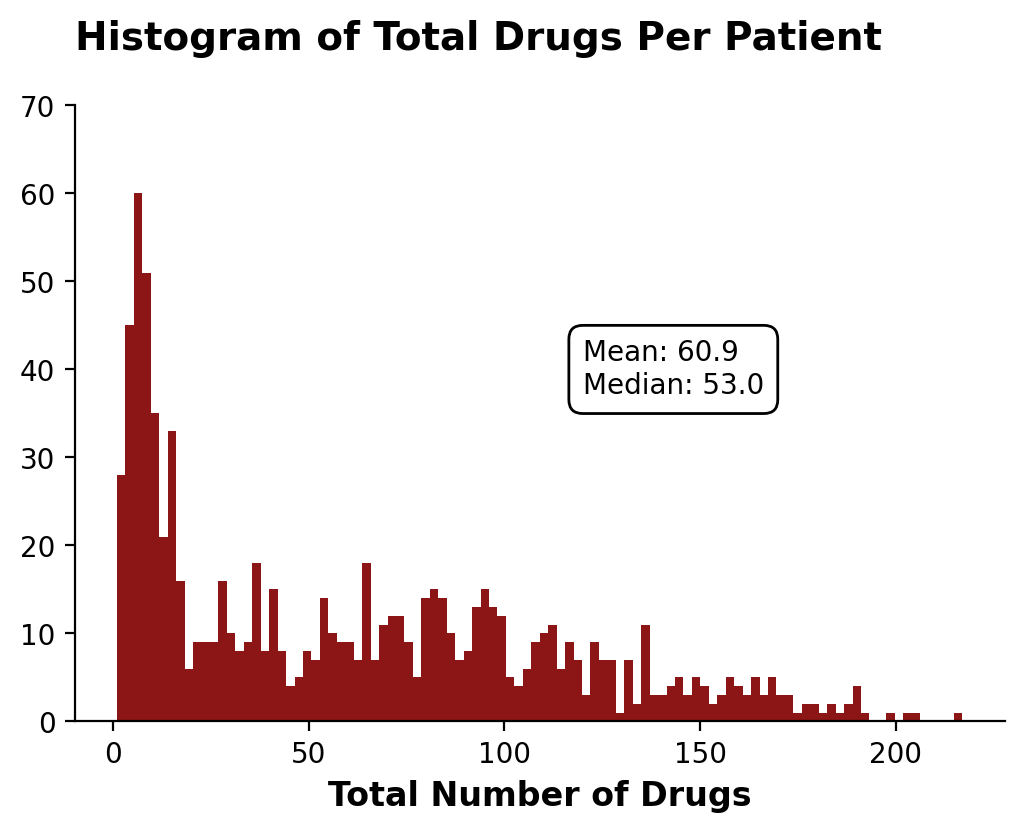

In [1063]:
# Prepare data for plot
mean_drugs = sum_unique_drugs_per_person['unique_drugs_count'].mean()
median_drugs = sum_unique_drugs_per_person['unique_drugs_count'].median()

# Plot histogram
fig,ax = plt.subplots(figsize=(6,4))

ax.hist(sum_unique_drugs_per_person['unique_drugs_count'], bins=100, color=stanford_red)

# Add text for mean and median

text_for_plot = f'Mean: {round(mean_drugs,1)}\nMedian: {round(median_drugs,1)}'
ax.text(120, 40, text_for_plot, fontsize=10, ha='left', va='center', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Customize plot
ax.set_ylim(0,70)

ax.set_xlabel('Total Number of Drugs', fontweight='bold', fontsize=12)
ax.set_title('Histogram of Total Drugs Per Patient', fontweight='bold', fontsize=14, loc='left', pad=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

## **c. What is the average duration that the Simvastatin 40 mg oral tablet is taken for?**

### 5c. Answer

The mean duration that the Simvastatin 40 mg oral tablet is taken is 40.9 days with a median of 29.0 days.

I included data from both “Simvastatin 40 mg oral tablet (Zocor)” and “Simvastatin 40 mg oral tablet” in the above calculation.

### 5c. Code & Work

In [1007]:
# Search concept table for Simvastatin 40mg
simvastatin_40mg_concept_df = concept_df[concept_df['concept_name'].str.contains('Simvastatin 40 mg oral tablet', case=False)]
simvastatin_40mg_concept_df

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason
200,1539406,Simvastatin 40 MG Oral Tablet [Zocor],Drug,RxNorm,Branded Drug,S,152923,1970-01-01,2099-12-31,NaN
2618,42708403,ezetimibe 10 MG / Simvastatin 40 MG Oral Table...,Drug,RxNorm,Branded Drug,S,1245441,2012-05-07,2099-12-31,NaN
3200,1539407,Simvastatin 40 MG Oral Tablet,Drug,RxNorm,Clinical Drug,S,198211,1970-01-01,2099-12-31,NaN
4793,19112569,ezetimibe 10 MG / Simvastatin 40 MG Oral Tablet,Drug,RxNorm,Clinical Drug,S,476350,1970-01-01,2099-12-31,NaN


In [1051]:
# Query table for both the generic and branded drug, 
simvastatin_40mg_drug_uses_df = drug_exposure_df.query('drug_concept_id in [1539406, 1539407]').reset_index(drop=True)

# Change to drug start and end dates to datetime
simvastatin_40mg_drug_uses_df['drug_exposure_start_DATETIME'] = pd.to_datetime(simvastatin_40mg_drug_uses_df['drug_exposure_start_DATE'])
simvastatin_40mg_drug_uses_df['drug_exposure_end_DATETIME'] = pd.to_datetime(simvastatin_40mg_drug_uses_df['drug_exposure_end_DATE'])

# Get duration (end date - start date) and mean days across drug use occurances
duration_simvastatin_40mg = (simvastatin_40mg_drug_uses_df['drug_exposure_end_DATETIME'] - simvastatin_40mg_drug_uses_df['drug_exposure_start_DATETIME']).dt.days
print(duration_simvastatin_40mg.mean())
print(duration_simvastatin_40mg.median())

40.91489361702128
29.0


### 5c. Visualization

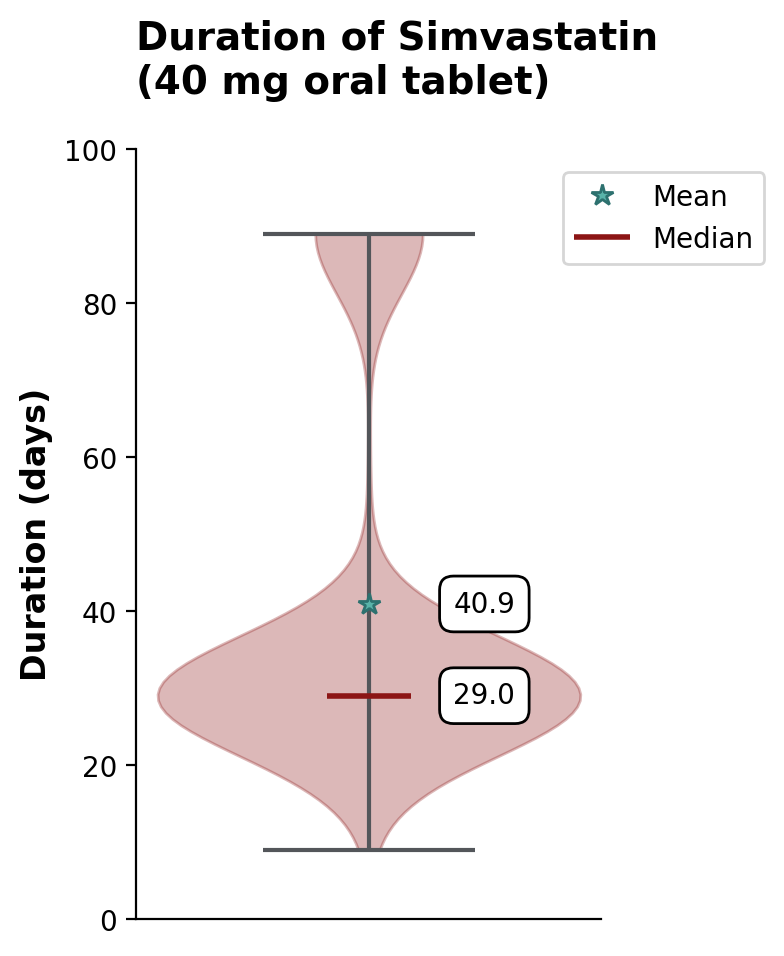

In [1166]:
# Prep data for plot (get mean and median)
mean = np.mean(duration_simvastatin_40mg)
median = np.median(duration_simvastatin_40mg)

# Plot total drug use in violin plot
fig, ax = plt.subplots(figsize=(3, 5))
violin_parts = ax.violinplot(duration_simvastatin_40mg)

# Change fill color of violin
for pc in violin_parts['bodies']:
    pc.set_facecolor(stanford_red)
    pc.set_edgecolor(stanford_red)

# Change bar and line color of violin
violin_parts['cbars'].set_color(stanford_grey)
violin_parts['cmaxes'].set_color(stanford_grey)
violin_parts['cmins'].set_color(stanford_grey)

# Add mean marker and text
ax.plot(1, mean, '*', color='#59B3A9', markersize=8, markeredgecolor='#2D716F', markeredgewidth=1, label='Mean')
ax.text(1.1, mean, round(mean,1), fontsize=10, ha='left', va='center', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Add median marker and text
ax.hlines(median, .95, 1.05, colors=stanford_red, linestyles='-', lw=2, label='Median')
ax.text(1.1, median, round(median, 1), fontsize=10, ha='left', va='center', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Customize the plot
ax.set_ylim(0,100)
ax.set_xticks([])

ax.set_ylabel('Duration (days)', fontweight='bold', fontsize=12)
ax.set_title('Duration of Simvastatin\n(40 mg oral tablet)', fontsize=14, fontweight='bold', loc='left', pad=20)

ax.legend(bbox_to_anchor=(1.35, .97), borderaxespad=0, loc='upper right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()